In [72]:
from collections import *
import random
import re
import tensorflow as tf
from utils import *

# Working with Sequences

In [6]:
class Data(DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = tf.range(1, T+1, dtype=tf.float32)
        self.x = tf.sin(0.01 * self.time) + tf.random.normal([T]) * 0.2

    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = tf.stack(features, 1)
        self.labels = tf.reshape(self.x[self.tau:], (-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

In [7]:
data = Data()

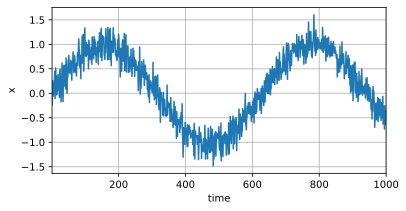

In [8]:
plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

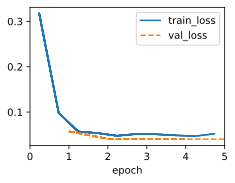

In [9]:
model = LinearRegressionKeras(lr=0.01)
trainer = Trainer(max_epochs=5)
trainer.fit(model, data)

## Prediction
check how well our model performs at one-step-ahead prediction.

In [14]:
onestep_preds = model(data.features).numpy()

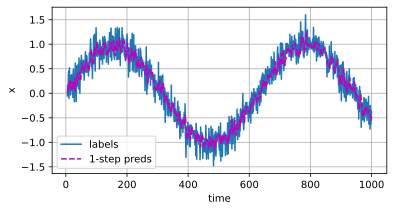

In [15]:
plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
     legend=['labels', '1-step preds'], figsize=(6, 3))

For an observed sequence up to time step t, its predicted output at time step t+k is the ***k-step-ahead prediction***. As we predict further in time by increasing k, the errors accumulate and the quality of the prediction degrades, often dramatically.

Take a closer look at the difficulties in k-step-ahead predictions by computing predictions on the entire sequence for k=1,4,16,64.

In [49]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i: i+data.T-data.tau-k+1])

    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(tf.stack(features[i:i+data.tau], 1))
        features.append(tf.reshape(preds, -1))
    return features[data.tau:]

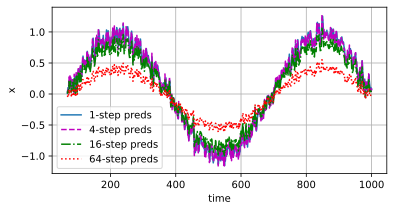

In [50]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
plot(data.time[data.tau+steps[-1]-1:],
     [preds[k - 1].numpy() for k in steps], 'time', 'x',
     legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

# Converting Raw Text into Sequence Data

In [102]:
class TimeMachine(DataModule):
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        # batch_size: the number of subsequence examples in each minibatch
        # num_steps: the subsequence length in tokens
        super().__init__()
        self.save_hyperparameters()

        corpus, self.vocab = self.build(self._download())
        array = tf.constant([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:, :-1], array[:, 1:]

    def _download(self):
        r = requests.get(DATA_URL + 'timemachine.txt',
                         stream=True, verify=True)
        with open('./data/timemachine.txt', 'wb') as f:
            f.write(r.content)
        return r.content.decode('utf-8')

    def _preprocess(self, text):
        # ignore punctuation and capitalization
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        #  tokenize our preprocessed text into a sequence of characters.
        return list(text)

    def build(self, raw_text, vocab=None):
        # corpus: a list of token indices
        # vocab: the vocabulary of The Time Machine corpus.
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None:
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train+self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)


data = TimeMachine(batch_size=2, num_steps=10)

In [65]:
raw_text = data._download()

In [66]:
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [67]:
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

**Tokenization**

Tokens are the atomic (indivisible) units of text.

In [75]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

**Vocabulary**

vocabularies, i.e., objects that associate each distinct token value with a unique index.

In [78]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # Count token frequencies
        counter = Counter(tokens)
        self.token_freqs = sorted(
            counter.items(), key=lambda x: x[1], reverse=True)

        # The list of unique tokens
        self.idx_to_token = list(sorted(set(
            ['<unk>'] + reserved_tokens +
            [token for token, freq in self.token_freqs if freq >= min_freq])))

        self.token_to_idx = {token: idx for idx,
                             token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):
        return self.token_to_idx['<unk>']

In [87]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


**Putting It All Together**

In [89]:
corpus, vocab = data.build(raw_text)

In [90]:
len(corpus), len(vocab)

(173428, 28)

**Exploratory Language Statistics**

construct a vocabulary from words used in The Time Machine and print the 10 most frequently occurring words.

In [95]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Word frequency tends to follow a power law distribution (specifically the Zipfian) as we go down the ranks. 

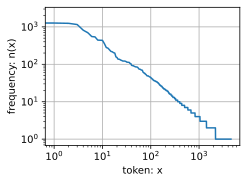

In [96]:
freqs = [freq for token, freq in vocab.token_freqs]
plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
     xscale='log', yscale='log')

In [97]:
# bigram frequency
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [98]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

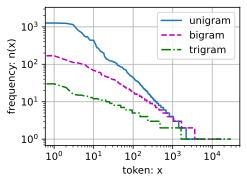

In [100]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
     ylabel='frequency: n(x)', xscale='log', yscale='log',
     legend=['unigram', 'bigram', 'trigram'])

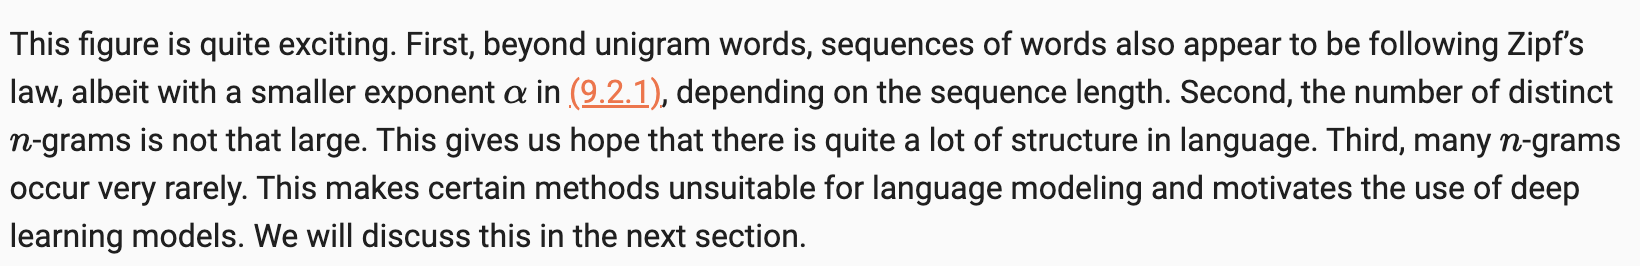

# Language Models

**Partitioning Sequences**:

In [103]:
data = TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tf.Tensor(
[[23  6 19 26  0 24  6 13 13  0]
 [13 10 21 10  6 20  0 16  7  0]], shape=(2, 10), dtype=int32) 
Y: tf.Tensor(
[[ 6 19 26  0 24  6 13 13  0 21]
 [10 21 10  6 20  0 16  7  0 21]], shape=(2, 10), dtype=int32)


# Recurrent Neural Networks

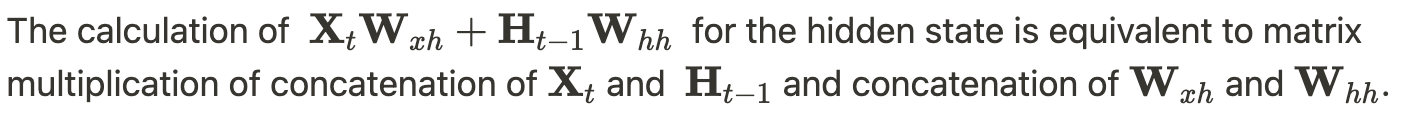

A simple RNN language model consists of input encoding, RNN modeling, and output generation. During training, gradient clipping can mitigate the problem of exploding gradients but does not address the problem of vanishing gradients. In the experiment, we implemented a simple RNN language model and trained it with gradient clipping on sequences of text, tokenized at the character level. By conditioning on a prefix, we can use a language model to generate likely continuations

In [104]:
X, W_xh = tf.random.normal((3, 1)), tf.random.normal((1, 4))
H, W_hh = tf.random.normal((3, 4)), tf.random.normal((4, 4))
tf.matmul(X, W_xh) + tf.matmul(H, W_hh)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 1.2822056 ,  4.57846   , -1.430795  , -1.5328377 ],
       [-1.6635442 , -3.6015728 ,  1.6067379 , -0.16860518],
       [-2.165846  , -2.5766008 ,  0.68123674, -1.8059641 ]],
      dtype=float32)>

In [108]:
tf.matmul(tf.concat((X, H), 1), tf.concat((W_xh, W_hh), 0))

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 1.2822056 ,  4.57846   , -1.430795  , -1.5328377 ],
       [-1.6635442 , -3.601573  ,  1.6067379 , -0.16860533],
       [-2.1658463 , -2.5766008 ,  0.6812368 , -1.8059642 ]],
      dtype=float32)>

## RNN Model

In [230]:
class RNN(Module):
    """Recurrent layer"""

    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = tf.Variable(tf.random.normal(
            (num_inputs, num_hiddens)) * sigma)
        self.W_hh = tf.Variable(tf.random.normal(
            (num_hiddens, num_hiddens)) * sigma)
        self.b_h = tf.Variable(tf.zeros(num_hiddens))

    def forward(self, X, state=None):
        # X shape (num_steps, batch_size, num_inputs)
        # compute the output and hidden state at any time step
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = tf.zeros((X.shape[1], self.num_hiddens))
        else:
            state, = state
            state = tf.reshape(state, (-1, self.num_hiddens))
        outputs = []
        for x in X:
            # iterate over steps
            # x: 2x16, W_xh: 16x32, state: 2:32, W_hh: 32x32, b_h: 32
            state = tf.tanh(tf.matmul(x, self.W_xh) +
                            tf.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [231]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
X = tf.ones((num_steps, batch_size, num_inputs))
rnn = RNN(num_inputs, num_hiddens)
outputs, state = rnn(X)

In [232]:
print("outputs: (", len(outputs), *outputs[0].shape, ')')
print("state:", state.shape)
print("X:", X.shape)

outputs: ( 100 2 32 )
state: (2, 32)
X: (100, 2, 16)


## RNN-based Language Model

In [233]:
class RNNLM(Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        # When training language models, the inputs and outputs are from the same vocabulary.
        # they have the same dimension = the vocabulary size.
        self.W_hq = tf.Variable(tf.random.normal(
            (self.rnn.num_hiddens, self.vocab_size)) * self.rnn.sigma)  # (num_hiddens,V)
        self.b_q = tf.Variable(tf.zeros(self.vocab_size))  # (V)

    def training_step(self, batch):
        l = self.loss(self(*batch[:1]), batch[-1])
        self.plot('ppl', tf.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', tf.exp(l), train=False)

    def one_hot(self, X):
        # X.T: (num_steps, batch_size)
        # Output shape: (num_steps, batch_size, vocab_size)
        return tf.one_hot(tf.transpose(X), self.vocab_size)

    def output_layer(self, rnn_outputs):
        """The language model uses a fully connected output layer to 
        transform RNN outputs into token predictions at each time step."""
        # H:(batch_size, num_hiddens)
        outputs = [tf.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        # outputs: (num_steps, batch_size, V)
        return tf.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)  # (num_steps, batch_size, vocab_size)
        # (num_steps, batch_size, num_hiddens)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        """generates a continuation, one character at a time, 
        after ingesting a user-provided prefix"""
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = tf.constant([[outputs[-1]]])
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            # When looping through the characters in prefix, 
            # we keep passing the hidden state to the next time step 
            # but do not generate any output.
            if i < len(prefix) - 1: # Warm-up period
                outputs.append(vocab[prefix[i+1]])
            else:
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(tf.reshape(tf.argmax(Y, axis=2),1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [234]:
model = RNNLM(rnn, num_inputs)
outputs = model(tf.ones((batch_size, num_steps), dtype=tf.int64))
outputs.shape

TensorShape([2, 100, 16])

**One-Hot Encoding**

A one-hot encoding is a vector whose length is given by the size of the vocabulary N, where all entries are set to 0, except for the entry corresponding to our token, which is set to 1. 

In [224]:
tf.one_hot(tf.constant([0, 2, 3, 4]), 5)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

## Gradient Clipping

In [225]:
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = len(
            self.val_dataloader) if self.val_dataloader is not None else 0

    def prepare_model(self, model):
        model.trainer = self  # ?
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def prepare_batch(self, batch):
        return batch

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0

        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.training = True
        for batch in self.train_dataloader:
            with tf.GradientTape() as t:
                loss = self.model.training_step(self.prepare_batch(batch))
            grads = t.gradient(loss, self.model.trainable_variables)

            if self.gradient_clip_val > 0:
                grads = self.clip_gradients(self.gradient_clip_val, grads)
            # if self.gradient_clip_val
            self.optim.apply_gradients(
                zip(grads, self.model.trainable_variables))
            self.train_batch_idx += 1

        if self.val_dataloader is None:
            return

        self.model.training = False
        for batch in self.val_dataloader:
            self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx = 0

    def clip_gradients(self, grad_clip_val, grads):
        grad_clip_val = tf.constant(grad_clip_val, dtype=tf.float32)
        new_grads = [tf.convert_to_tensor(grad) if isinstance(
            grad, tf.IndexedSlices) else grad for grad in grads]
        norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)
                            for grad in new_grads)))
        if tf.greater(norm, grad_clip_val):
            for i, grad in enumerate(new_grads):
                new_grads[i] = grad * grad_clip_val / norm
            return new_grads
        return grads

## Training

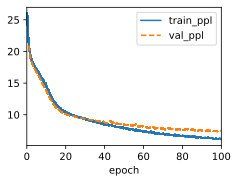

In [237]:
data = TimeMachine(batch_size=1024, num_steps=32)
with try_gpu():
    rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
    model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
trainer = Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

## Decoding

In [238]:
model.predict('it has', 20, data.vocab)

'it has in the time travell'

# RNN Concise Implementation

In [69]:
class RNNKeras(Module):
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        # Fully-connected RNN where the output is to be fed back to input.
        self.rnn = tf.keras.layers.SimpleRNN(num_hiddens, return_sequences=True, return_state=True, time_major=True)
        
    def forward(self, X, H=None):
        outputs, H = self.rnn(X, H)
        return outputs, H

In [80]:
class RNNLMKeras(RNNLM):
    def init_params(self):
        self.linear = tf.keras.layers.Dense(self.vocab_size)
        
    def output_layer(self, hiddens):
        return tf.transpose(self.linear(hiddens), (1,0,2))

In [81]:
data = TimeMachine(batch_size=1024,num_steps=32)
rnn = RNNKeras(num_hiddens=32)
model = RNNLMKeras(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasgzhbgnhvxxgnhvxxdwvk'

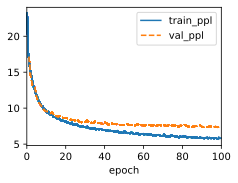

In [82]:
with try_gpu():
    trainer = Trainer(max_epochs=100, gradient_clip_val=1)
    trainer.fit(model, data)

In [78]:
model.predict('it has', 20, data.vocab)

'it has an the the the the '

# Backpropagation Through Time